# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
from pyspark.sql import functions as F
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler,Normalizer,StringIndexer
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier,LinearSVC



import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Spark Project Mini") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
path = "mini_sparkify_event_data.json"
data = spark.read.json(path)

In [4]:
data.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

In [6]:
data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [4]:
# check for records without userId and sessionId
data.select("userId").dropDuplicates().sort("userId").show()

# drop Nan for userId and sessionId
data_valid = data.dropna(how = "any", subset = ["userId", "sessionId"])

# drop invalid userId 
data_clean = data_valid.filter(data_valid["userId"] != "")

# check if there's any more invalid userId and sessionId
data_clean.select(["userId"]).where(data_clean.userId == "").collect()
data_clean.select(["sessionId"]).where(data_clean.sessionId == "").collect()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



[]

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [51]:
# create new variable 'churn' for users who canceled
flag_cancellation_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
data_clean = data_clean.withColumn("churn", flag_cancellation_event("page"))

In [52]:
# create new variable 'downgrade' for users who downgraded
flag_downgrade_event = udf(lambda x: 1 if x == "Downgrade" else 0, IntegerType())
data_clean = data_clean.withColumn("downgrade", flag_downgrade_event("page"))

In [46]:
data_clean.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', churn=0, downgrade=0)

In [66]:
# plotting the number of songs played by users who churned and users who stayed
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)
data_clean = data_clean.withColumn("hour", get_hour(data_clean.ts))
songs_in_hour_churn = data_clean.filter(data_clean.churn == 1).groupby(data_clean.hour).count().orderBy(data_clean.hour.cast("float"))
songs_in_hour_unchurn = data_clean.filter(data_clean.churn == 0).groupby(data_clean.hour).count().orderBy(data_clean.hour.cast("float"))
songs_in_hour_pd_churn = songs_in_hour_churn.toPandas()
songs_in_hour_pd_churn.hour = pd.to_numeric(songs_in_hour_pd_churn.hour)
songs_in_hour_pd_unchurn = songs_in_hour_unchurn.toPandas()
songs_in_hour_pd_unchurn.hour = pd.to_numeric(songs_in_hour_pd_unchurn.hour)


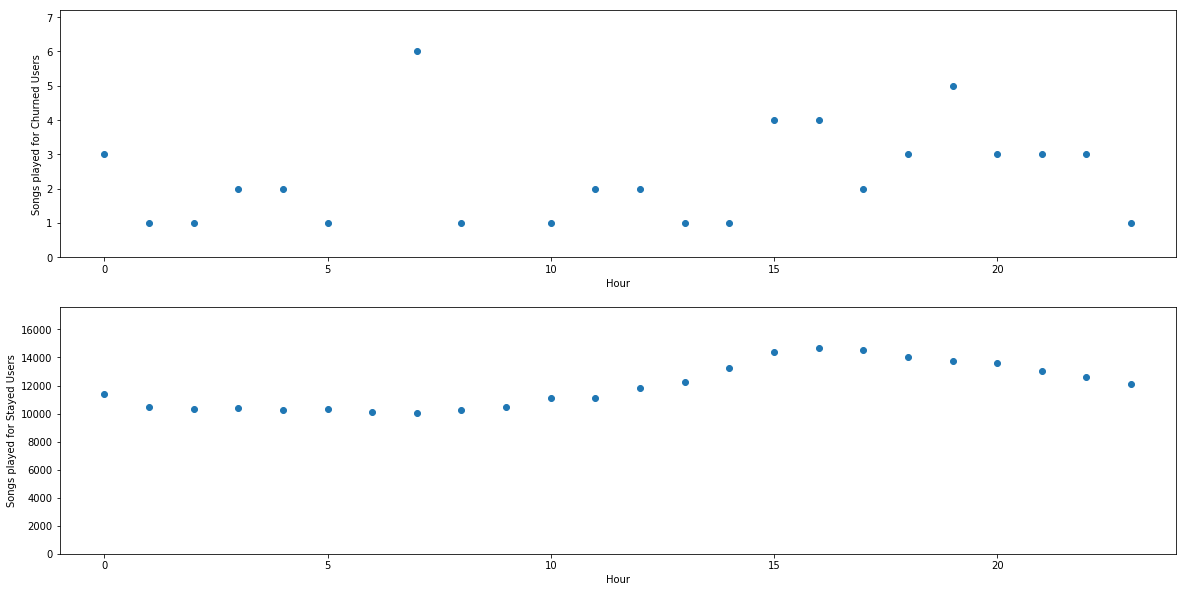

In [67]:
# plot
plt.figure(figsize=(20,10))

plt.subplot(2, 1, 1)
plt.scatter(songs_in_hour_pd_churn["hour"], songs_in_hour_pd_churn["count"])
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(songs_in_hour_pd_churn["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played for Churned Users");

plt.subplot(2, 1, 2)
plt.scatter(songs_in_hour_pd_unchurn["hour"], songs_in_hour_pd_unchurn["count"])
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(songs_in_hour_pd_unchurn["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played for Stayed Users");

plt.show()

According to the plots on the number of songs played during different hours for users who churned vs who didn't churn, it's clear that users who churned play much less than users who did not. So churned users didn't use the service as much as users who stayed.

In [68]:
# plotting the number of songs played by users who downgraded and users who did not downgrade
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)
data_clean = data_clean.withColumn("hour", get_hour(data_clean.ts))
songs_in_hour_dg = data_clean.filter(data_clean.downgrade == 1).groupby(data_clean.hour).count().orderBy(data_clean.hour.cast("float"))
songs_in_hour_notdg = data_clean.filter(data_clean.downgrade == 0).groupby(data_clean.hour).count().orderBy(data_clean.hour.cast("float"))
songs_in_hour_pd_dg = songs_in_hour_dg.toPandas()
songs_in_hour_pd_dg.hour = pd.to_numeric(songs_in_hour_pd_dg.hour)
songs_in_hour_pd_notdg = songs_in_hour_notdg.toPandas()
songs_in_hour_pd_notdg.hour = pd.to_numeric(songs_in_hour_pd_notdg.hour)

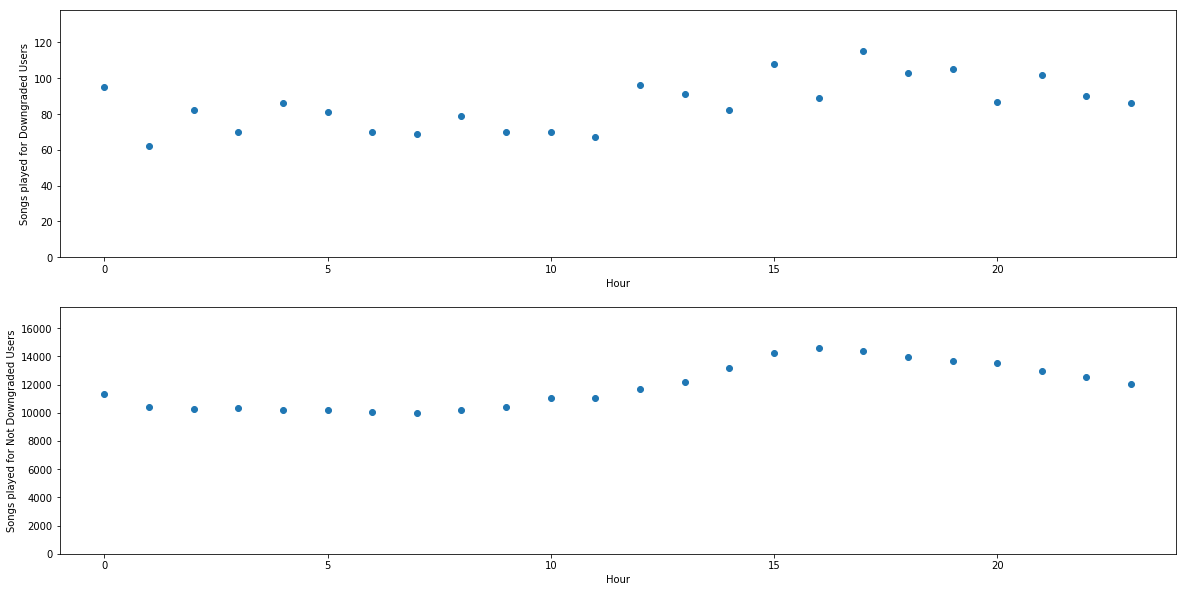

In [69]:
# plot
plt.figure(figsize=(20,10))

plt.subplot(2, 1, 1)
plt.scatter(songs_in_hour_pd_dg["hour"], songs_in_hour_pd_dg["count"])
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(songs_in_hour_pd_dg["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played for Downgraded Users");

plt.subplot(2, 1, 2)
plt.scatter(songs_in_hour_pd_notdg["hour"], songs_in_hour_pd_notdg["count"])
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(songs_in_hour_pd_notdg["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played for Not Downgraded Users");

plt.show()

Similar pattern for users who downgraded vs users who did not downgrade, that is, users who downgraded didn't use the service as much as users who did not downgrade.

In [7]:
# check for behavior for users who stayed vs who churned/downgraded
# use a window function and cumulative sum to distinguish each user's data as either pre or post churn events
from pyspark.sql import Window
windowval_churn = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
data_clean = data_clean.withColumn("phase_churn", Fsum("churn").over(windowval_churn))

In [8]:
# use a window function and cumulative sum to distinguish each user's data as either pre or post downgrade events
from pyspark.sql import Window
windowval_dg = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
data_clean = data_clean.withColumn("phase_dg", Fsum("downgrade").over(windowval_dg))
data_clean.select(["userId", "firstname", "ts", "page", "level", "phase_churn",'phase_dg']).where(data_clean.userId == "30").sort("ts").collect()

[Row(userId='30', firstname='Colin', ts=1538352117000, page='NextSong', level='paid', phase_churn=0, phase_dg=6),
 Row(userId='30', firstname='Colin', ts=1538352394000, page='NextSong', level='paid', phase_churn=0, phase_dg=6),
 Row(userId='30', firstname='Colin', ts=1538352676000, page='NextSong', level='paid', phase_churn=0, phase_dg=6),
 Row(userId='30', firstname='Colin', ts=1538352899000, page='NextSong', level='paid', phase_churn=0, phase_dg=6),
 Row(userId='30', firstname='Colin', ts=1538352905000, page='Add to Playlist', level='paid', phase_churn=0, phase_dg=6),
 Row(userId='30', firstname='Colin', ts=1538353084000, page='NextSong', level='paid', phase_churn=0, phase_dg=6),
 Row(userId='30', firstname='Colin', ts=1538353218000, page='NextSong', level='paid', phase_churn=0, phase_dg=6),
 Row(userId='30', firstname='Colin', ts=1538353441000, page='NextSong', level='paid', phase_churn=0, phase_dg=6),
 Row(userId='30', firstname='Colin', ts=1538353687000, page='NextSong', level='pa

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [ ]:
data_clean.head()

1. Since female and male may have instrinsic difference in the preference for the service, so I included gender as a feature.

In [5]:
# 1. creating dummy for "gender" --> 'Gender'
gender_event = udf(lambda x: 1 if x == "F" else 0, IntegerType())
gender = data_clean\
    .select('userId','gender')\
    .dropDuplicates()\
    .withColumn("Gender", gender_event("gender"))


2. Users who use paid service will have a different service than users who are using free service, such as having commercials between the songs. Hence I include the service level as a feature.

In [14]:
data_clean.select(["userId",'level']).collect()

[Row(userId='30', level='paid'),
 Row(userId='9', level='free'),
 Row(userId='30', level='paid'),
 Row(userId='9', level='free'),
 Row(userId='30', level='paid'),
 Row(userId='9', level='free'),
 Row(userId='9', level='free'),
 Row(userId='30', level='paid'),
 Row(userId='30', level='paid'),
 Row(userId='30', level='paid'),
 Row(userId='9', level='free'),
 Row(userId='9', level='free'),
 Row(userId='30', level='paid'),
 Row(userId='9', level='free'),
 Row(userId='9', level='free'),
 Row(userId='30', level='paid'),
 Row(userId='9', level='free'),
 Row(userId='74', level='free'),
 Row(userId='30', level='paid'),
 Row(userId='9', level='free'),
 Row(userId='74', level='free'),
 Row(userId='30', level='paid'),
 Row(userId='54', level='paid'),
 Row(userId='9', level='free'),
 Row(userId='74', level='free'),
 Row(userId='30', level='paid'),
 Row(userId='54', level='paid'),
 Row(userId='9', level='free'),
 Row(userId='74', level='free'),
 Row(userId='30', level='paid'),
 Row(userId='54', leve

In [6]:
# 2. creating dummy for "level" --> 'service_level'
service = udf(lambda x: 1 if x == "paid" else 0, IntegerType())
service_level = data_clean\
    .select('userId','level')\
    .dropDuplicates()\
    .withColumn("service", service("level"))\
    .drop('level')


3. By looking at the number of thumbs up and the number of thumbs down, we can get an approximation of how satisfied a user is, hence they are included as features.

In [7]:
# 3. creating variable for number of thumbs up, number of thumbs down
thumbs_up = data_clean \
    .select('userID','page') \
    .where(data_clean.page == 'Thumbs Up') \
    .groupBy('userID') \
    .count() \
    .withColumnRenamed('count', 'num_thumb_up') 

thumbs_down = data_clean \
    .select('userID','page') \
    .where(data_clean.page == 'Thumbs Down') \
    .groupBy('userID') \
    .count() \
    .withColumnRenamed('count', 'num_thumb_down')


4. It is also important to see if the customer churn happens to new users more often or old users. If it happens to new users more often, then that means the service may be confusing for users to begin using. If it happens to old users more often, then that means the service may need to improve their service, such as adding more artists.

In [8]:
# 4. creating variable for time since registration
period = data_clean \
    .select('userId','registration','ts') \
    .withColumn('period', (data_clean.ts - data_clean.registration))\
    .groupby('userId')\
    .agg({'period':'max'})\
    .withColumnRenamed('max(period)', 'period')\
    .select('userId', (F.col('period')/1000/3600/24).alias('period'))


5. Similar argument as above, the number of songs listened differentiate if customer churn happens more often for new users or old users.

In [9]:
# 5. create variable for total number of songs listened
num_songs = data_clean \
    .select('userId','song') \
    .groupby('userId')\
    .count()\
    .withColumnRenamed('count','num_songs')


6. Similar reasoning as above.

In [10]:
# 6. creating variable for total length of listening
total_length = data_clean \
    .select('userId','length')\
    .groupby('userId')\
    .sum()\
    .withColumnRenamed('sum(length)','total_length')


7. As mentioned above, the number of artitsts available for users to choose may influence users' decisions of staying or cancelling. Hence it's important to include the number of artists listened as one of the features.

In [11]:
# 7. creating variable for total number of artists listened
total_artists = data_clean \
    .filter(data_clean.page=="NextSong") \
    .select('userId','artist')\
    .dropDuplicates()\
    .groupby('userId')\
    .count()\
    .withColumnRenamed('count','total_artists')


8. This serve as a indicator of how satisfying a user is for the service.

In [12]:
# 8. variable for the number of songs added to the playlist
songs_added = data_clean\
    .select('userId','page')\
    .where(data_clean.page == 'Add to Playlist')\
    .groupby('userId')\
    .count()\
    .withColumnRenamed('count','songs_added')


9. We can use downgrade as an approxy to see how satisfied the users feel about the service, and if free service is enough for customers to stay using the service.

In [13]:
# 9. variable for users who downgraded
# create new variable 'downgrade' for users who downgraded
flag_downgrade_event = udf(lambda x: 1 if x == "Downgrade" else 0, IntegerType())
downgrade = data_clean\
    .select('userId','page')\
    .dropDuplicates()\
    .withColumn("downgrade", flag_downgrade_event("page"))\
    .drop('page')


Since our goal is to measure customer churn, I used cancellation as the label.

In [14]:
# constructing cancellation of service as the label
flag_cancel_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
label = data_clean.select('userId','page')\
    .dropDuplicates()\
    .withColumn("label", flag_downgrade_event("page"))\
    .drop('page')


In [15]:
# constructing the dataframe that contains the features and label
data = gender.join(service_level,'userId','outer')\
    .join(thumbs_up,'userId','outer')\
    .join(thumbs_down,'userId','outer')\
    .join(period,'userId','outer')\
    .join(num_songs,'userId','outer')\
    .join(total_length,'userId','outer')\
    .join(total_artists,'userId','outer')\
    .join(songs_added,'userId','outer')\
    .join(downgrade, 'userId','outer')\
    .join(label, 'userId','outer')\
    .drop('userId')\
    .fillna(0)

In [16]:
assembler = VectorAssembler(
    inputCols=["Gender", "service", "num_thumb_up",'num_thumb_down','period','num_songs','total_length','total_artists',\
              'songs_added','downgrade'],
    outputCol="features")

df = assembler.transform(data)


In [17]:
# normalizing features
scaler = Normalizer(inputCol="features", outputCol="features_norm")
df = scaler.transform(df)


In [45]:
df.show(1)

+------+-------+------------+--------------+----------------+---------+-----------------+-------------+-----------+---------+-----+--------------------+--------------------+
|Gender|service|num_thumb_up|num_thumb_down|          period|num_songs|     total_length|total_artists|songs_added|downgrade|label|            features|       features_norm|
+------+-------+------------+--------------+----------------+---------+-----------------+-------------+-----------+---------+-----+--------------------+--------------------+
|     1|      0|          17|             5|55.6436574074074|      381|66940.89735000003|          252|          7|        0|    0|[1.0,0.0,17.0,5.0...|[1.49381972973596...|
+------+-------+------------+--------------+----------------+---------+-----------------+-------------+-----------+---------+-----+--------------------+--------------------+
only showing top 1 row



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [18]:
# Split the full dataset into train, test, and validation sets.
train, remain = df.randomSplit([0.8, 0.2], seed=12345)
test, validation = remain.randomSplit([0.5, 0.5], seed=12345)

## Logictic Regression

In [21]:
# Logistic Regression
lr =  LogisticRegression()

On the first 80% of the data let's find the most accurate logistic regression model using 3-fold cross-validation with the following parameter grid:

- LogisticRegression regularization parameter: `[0.0, 0.1]`
- LogisticRegression max Iteration number: `[5, 10]`

In [22]:
paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr.regParam,[0.0, 0.1]) \
    .addGrid(lr.maxIter,[5, 10]) \
    .build()

crossval_lr = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid_lr,
                          evaluator=MulticlassClassificationEvaluator(metricName='f1'),
                          numFolds=3)


In [23]:
cvModel_lr = crossval_lr.fit(train)
cvModel_lr.avgMetrics

[0.9175803831437144,
 0.9175803831437144,
 0.9175803831437144,
 0.9175803831437144]

In [24]:
results_lr = cvModel_lr.transform(validation)

In [25]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Logistic Regression Metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_lr, {evaluator.metricName: "accuracy"})))

Logistic Regression Metrics:
Accuracy: 0.9445910290237467


## Gradient-boosted Tree

In [26]:
# Train a GBT model.
gbt = GBTClassifier(labelCol="label", featuresCol="features_norm")
paramGrid_gbt = ParamGridBuilder()\
    .addGrid(gbt.maxIter,[5, 10])\
    .addGrid(gbt.maxDepth,[4, 6])\
    .build()

evaluator_f1 = MulticlassClassificationEvaluator(metricName='f1')

crossval_gbt = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid_gbt,
                          evaluator=evaluator_f1,
                          numFolds=3)

In [27]:
cvModel_gbt = crossval_gbt.fit(train)
cvModel_gbt.avgMetrics

[0.9175803831437144,
 0.9175803831437144,
 0.9175803831437144,
 0.9175803831437144]

In [ ]:
results_gbt = cvModel_gbt.transform(validation)

In [ ]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Gradient-boosted Tree Metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_gbt, {evaluator.metricName: "accuracy"})))

## Linear Support Vector Machine

In [20]:
# Train a SVM model
# initialize the model
svm = LinearSVC()
# build grid search
paramGrid_svm = ParamGridBuilder()\
    .addGrid(svm.maxIter, [10,20])\
    .build()
# built cross-validation
crossval_svm = CrossValidator(estimator=svm,
                          estimatorParamMaps=paramGrid_svm,
                          evaluator=MulticlassClassificationEvaluator(metricName='f1'),
                          numFolds=3)

In [21]:
# fit the model
cvModel_svm = crossval_svm.fit(train)

NameError: name 'cvModel_smv' is not defined

In [22]:
cvModel_svm.avgMetrics

[0.9175934759314113, 0.9175934759314113]

In [23]:
results_svm = cvModel_svm.transform(validation)

In [25]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Support Vector Machine Metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_svm, {evaluator.metricName: "accuracy"})))

Support Vector Machine Metrics:
Accuracy: 0.9445910290237467


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.